In [1]:
import pims

def import_dataset(name_folder):
    """
    Imports and cleans up the data files in the name directory (removes
    incompletely scanned frames) and exports the resulting file as a
    TIFF file along with the relevant metadata. All files are exported
    to a "preprocessed_data" folder in the name folder (created if it
    does not already exist).
    
    :param str name_folder: Path to name folder containing data files.
    :return: 
    """
    

In [ ]:
def global_metadata(data_list):
    """
    Helper function that checks consistency of imaging settings between files
    in a dataset.
    """

In [1]:
import pims
import glob
import numpy as np

In [2]:
trim_series = False

In [3]:
name_folder = 'test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1'
dataset_name = name_folder.split('/')[-1]
file_path = ''.join([name_folder, '/', dataset_name, '*'])
file_list = glob.glob(file_path)

In [4]:
# We pull the individual data files into a list as pipeline objects. Pulling
# the metadata is deferred until the concatenation step since it forces a read
# from disk.
data = []
num_frames_series = []

for file in file_list:
    series = pims.Bioformats(file)
    series.bundle_axes = 'tczyx'
    data.append(series)

    num_frames_series.append((series.shape)[1])

num_frames_series = np.array(num_frames_series) # Numpy array more convenient
                                                # for later slicing

/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '


In [5]:
# Handle global metadata checks before reading data files
#for i, _ in enumerate(data):

num_frames = np.sum(num_frames_series)
num_series = num_frames_series.size
if trim_series:
    num_frames = num_frames - num_series
    num_frames_series = num_frames_series - 1
    end = -1
else:
    end = None

series_shape = data[0].shape
dataset_shape = (num_frames, series_shape[2], series_shape[3], series_shape[4],
                series_shape[5])
full_dataset = np.empty(dataset_shape)

series_start = 0
for i, _ in enumerate(data):
    series_end = series_start + num_frames_series[i]
    full_dataset[series_start:series_end] = data[i][0][:end]

    series_start = series_end

In [6]:
full_dataset.shape

(171, 2, 21, 256, 512)

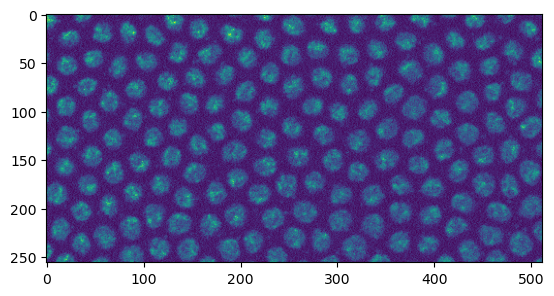

In [10]:
plt.imshow(full_dataset[100, 1, 10])

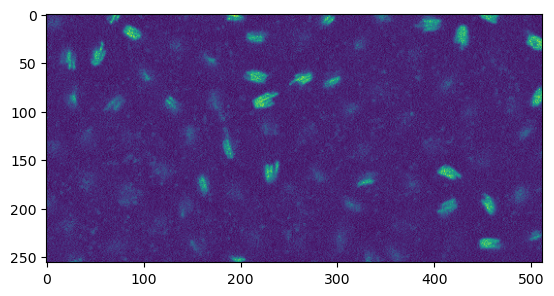

In [9]:
import matplotlib.pyplot as plt
plt.imshow(data[3][0][5][1][12])

In [6]:
(data[0].metadata)

<MetadataRetrieve> Available loci.formats.meta.MetadataRetrieve functions: ChannelAnnotationRefCount, ChannelColor, ChannelCount, ChannelID, ChannelName, ChannelPinholeSize, ChannelSamplesPerPixel, DatasetCount, DetectorAmplificationGain, DetectorAnnotationRefCount, DetectorCount, DetectorGain, DetectorID, DetectorSettingsID, DetectorType, DetectorZoom, DichroicAnnotationRefCount, DichroicCount, DichroicID, DichroicModel, ExperimentCount, ExperimenterAnnotationRefCount, ExperimenterCount, ExperimenterGroupCount, ExperimenterID, ExperimenterUserName, FilterCount, FilterSetCount, FolderCount, ImageAcquisitionDate, ImageAnnotationRefCount, ImageCount, ImageDescription, ImageID, ImageInstrumentRef, ImageName, ImageROIRefCount, InstrumentAnnotationRefCount, InstrumentCount, InstrumentID, LaserID, LaserLaserMedium, LaserModel, LaserType, LaserWavelength, LightPathAnnotationRefCount, LightPathEmissionFilterRefCount, LightPathExcitationFilterRefCount, LightSourceAnnotationRefCount, LightSource

In [80]:
from inspect import signature

metadata_retrieve = str(data[0].metadata).split(', ')
metadata_retrieve[0] = metadata_retrieve[0].split(': ')[1]

num_series = data[0].metadata.ImageCount()
global_metadata = {}
for field in metadata_retrieve:
    # First write metadata as dict of function objects
    field_data_func = getattr(data[0].metadata, field)

    # Convert each function object into a list of values for each series and
    # channel, indexed in that order.

    # Using exceptions for flow control is not ideal, but the PIMS wrappers
    # use variable-length arguments so I don't have a good way of inspecting
    # the argument structure for each metadata object a priori.
    try:
        field_data = field_data_func()
    except TypeError:
    
        try:
            field_data = []
            for i in range(num_series):
                field_data.append(field_data_func(i))
        except TypeError:

            field_data = []
            for i in range(num_series):
                num_channels = data[0].metadata.ChannelCount(i)
                series_field_data = []
                for j in range(num_channels):

                    # This handles the weird argument shape that doesn't
                    # match channel structure for ChannelAnnotationRefCount
                    try:
                        series_field_data.append(field_data_func(i, j))
                    except Exception:
                        series_field_data.append(None)
                        
                field_data.append(series_field_data)

    global_metadata[field] = field_data

In [81]:
global_metadata

{'ChannelAnnotationRefCount': [[0, 0]],
 'ChannelColor': [[16711935, -16776961]],
 'ChannelCount': [2],
 'ChannelID': [['Channel:0:0', 'Channel:0:1']],
 'ChannelName': [['ChS1', 'ChS2']],
 'ChannelPinholeSize': [[31.599400000000003, 31.599400000000003]],
 'ChannelSamplesPerPixel': [[1, 1]],
 'DatasetCount': 0,
 'DetectorAmplificationGain': [[1.0, 1.0]],
 'DetectorAnnotationRefCount': [[0, 0]],
 'DetectorCount': [2],
 'DetectorGain': [[565.0, 565.0]],
 'DetectorID': [['Detector:0:0', 'Detector:0:1']],
 'DetectorSettingsID': [['Detector:0:0', 'Detector:0:1']],
 'DetectorType': [['PMT', 'PMT']],
 'DetectorZoom': [[2.0, 2.0]],
 'DichroicAnnotationRefCount': [[0, 0]],
 'DichroicCount': [3],
 'DichroicID': [['Dichroic:0:0', 'Dichroic:0:1']],
 'DichroicModel': [['MBS 488/561', 'Plate']],
 'ExperimentCount': 0,
 'ExperimenterAnnotationRefCount': [0],
 'ExperimenterCount': 1,
 'ExperimenterGroupCount': 0,
 'ExperimenterID': ['Experimenter:0'],
 'ExperimenterUserName': ['LSM User'],
 'FilterCoun

In [74]:
data[1].metadata.ObjectiveAnnotationRefCount(0, 0)

0

In [32]:
data[1].metadata.LaserID(0)

TypeError: getLaserID() takes exactly 2 arguments (1 given)

In [23]:
data[1].metadata.ImageAcquisitionDate(0)

'2023-04-03T04:58:20'

In [47]:
data[1].metadata.ChannelCount(0)

2

In [11]:
data[0].metadata.PlaneDeltaT(0, 0)

0.0

In [22]:
data[0].metadata.DetectorSettingsID(0, 0)

'Detector:0:0'

In [44]:
data[0][0].metadata

{'frame': array([[[  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,
           24,  26,  28,  30,  32,  34,  36,  38,  40],
         [  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,
           25,  27,  29,  31,  33,  35,  37,  39,  41]],
 
        [[ 42,  44,  46,  48,  50,  52,  54,  56,  58,  60,  62,  64,
           66,  68,  70,  72,  74,  76,  78,  80,  82],
         [ 43,  45,  47,  49,  51,  53,  55,  57,  59,  61,  63,  65,
           67,  69,  71,  73,  75,  77,  79,  81,  83]],
 
        [[ 84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104, 106,
          108, 110, 112, 114, 116, 118, 120, 122, 124],
         [ 85,  87,  89,  91,  93,  95,  97,  99, 101, 103, 105, 107,
          109, 111, 113, 115, 117, 119, 121, 123, 125]],
 
        [[126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148,
          150, 152, 154, 156, 158, 160, 162, 164, 166],
         [127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149,
          151, 153, 155, 157, 

In [9]:
data[0].get_metadata_raw()

{'Laser Acquire #2': 'True',
 'Laser Acquire #1': 'True',
 'Y position for position #2': '0.0',
 'Y position for position #1': '0.0',
 'Timer Acquire #6': 'True',
 'Timer Acquire #5': 'True',
 'Timer Acquire #4': 'True',
 'Timer Acquire #3': 'True',
 'Timer Acquire #2': 'True',
 'Timer Acquire #1': 'True',
 'IlluminationChannel Acquire #2': 'True',
 'IlluminationChannel Acquire #1': 'True',
 'X position for position #2': '0.0',
 'X position for position #1': '0.0',
 'Marker Acquire #7': 'True',
 'DetectionChannel Acquire #2': 'True',
 'Marker Acquire #6': 'True',
 'Marker Acquire #5': 'True',
 'DetectionChannel Acquire #1': 'True',
 'Marker Acquire #4': 'True',
 'Marker Acquire #3': 'True',
 'Marker Acquire #2': 'True',
 'DataChannel Acquire #2': 'True',
 'Marker Acquire #1': 'True',
 'DataChannel Acquire #1': 'True',
 'Recording Acquire #1': 'True',
 'ApplicationName': 'AimApplication\x00',
 'BeamSplitter Acquire #3': 'True',
 'BeamSplitter Acquire #2': 'True',
 'BeamSplitter Acquire 

In [41]:
lif_test = pims.Bioformats('test_data/2021-06-14/p2pdpwt/p2pdpwt.lif')

/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '


In [42]:
lif_metadata = lif_test.metadata

In [43]:
lif_metadata.ImageCount()

3

## To-do
- Add metadata handling bit (grab relevant info using pipeline object, then use frame-by-frame for time).
    - Might be useful to make it so we can easily choose extra metadata to track throughout the imaging.

In [85]:
import tifffile

In [87]:
tiffle_test = tifffile.TiffFile('test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/p2pdp_zld-sites-ctrl_fwd_1_A.lsm')